In [7]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("Setting GPU Memory Growth...")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization


print("TF version:", tf.__version__)
print("KT version:", kt.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Number of best models
numBestModels = 1 

# Validation set percentage
val_size = 0.3

# Batch size
batch = 1024

# Nodos internos
hidden_nodes = 10

# Units parameters
minUnits = 10
maxUnits = 50
stepsUnits = 10
defaultUnits = 30

# Dropout Parameters
minDropout = 0
maxDropout = 0.33
defaultDropout = .25

# Establecer medida de loss
loss = "mean_absolute_error"

# Learning rate
learningRate = [0.0, 1e-2, 1e-3, 1e-4]

# Model metrics
modelMetrics = [keras.metrics.MAE, tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]

# Optimizer objetive: error percetange with the validation set 
objective = kt.Objective('val_mean_absolute_error', 'min')

# Maximum model trials and executions
trials = 40
executions = 2

# Epochs
epchs = 100

TF version: 2.15.0
KT version: 1.0.5
Panda version: 2.2.0
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Please install GPU version of TF
Num GPUs Available:  0
Build with CUDA:  False


C:\Users\hecto\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [8]:
df = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_PV_W20_H20.csv",
                delimiter=";")

dfTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_PV_W20_H20.csv",
                delimiter=";")

# X = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_Weather_W7.csv",
#                        delimiter=",")

# xTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_Weather_W7.csv",
#                    delimiter=",")

# projectNameBO = "W7_PV-gru-bo"
# projectNameRS = "W7_PV-gru-rs"

# projectNameRS = "PV_W140_H20-gru-rs"
# projectNameBO = "PV_W140_H20-gru-bo"

projectNameRS = "CPU-PV_W20_H20-gru-rs"
projectNameBO = "CPU-PV_W20_H20-gru-bo"

W=20
H=20

In [9]:
# # Old data preprocessing: each row will contain the 20 measures for each day , and the 10 measures for the following day
# # X = pd.DataFrame(np.array(training).reshape(-1, W))
# Y = pd.DataFrame.copy(X)
# yTest = pd.DataFrame.copy(xTest)

# Y.columns = ["col_{}".format(i) for i in range(W+1, (2*W)+1)]
# Y = Y.drop(0)
# Y = Y.reset_index(drop = True)
# Y.loc[len(Y)] = np.zeros(numPredictions)

# # Last row is deleted because it is the one used for the real prediction, 
# # it is not useful for the training of the model. 
# X.drop(X.tail(1).index, inplace = True)
# Y.drop(Y.tail(1).index, inplace = True)

# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")

# #  Uncomment in order to normalize data
# # Data Normalization
# # scaler = MinMaxScaler()
# # X = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(1, 21)])
# # Y = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(21, 41)])


In [10]:
# Preprocessing for PV_W_H type files:

#  Uncomment in order to normalize data
# Data Normalization

df = df.replace(',', '.', regex=True)
dfTest = dfTest.replace(',', '.', regex=True)

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df))
dfTest = pd.DataFrame(scaler.fit_transform(dfTest))

# Filter for PV data
X = df.iloc[:, 0:W]
xTest = dfTest.iloc[:, 0:W]

Y = df.iloc[:, W:]
yTest = dfTest.iloc[:, W:]

numPredictions = H

print(X)
print(yTest)

           0         1         2         3         4         5         6   \
0    0.202547  0.343202  1.000000  0.842291  0.577134  0.745918  0.996233   
1    0.426514  0.294835  0.574558  0.485647  0.827078  0.838485  0.959061   
2    0.230347  0.267902  0.116575  0.189409  0.229192  0.324692  0.254022   
3    0.815427  0.732371  0.665736  0.544064  0.661029  0.580754  0.651991   
4    0.586870  0.752408  0.486835  0.536889  0.585460  0.500163  0.220289   
..        ...       ...       ...       ...       ...       ...       ...   
359  0.774161  0.837234  0.787854  0.887529  0.847939  0.857222  0.794488   
360  0.411077  0.462226  0.514200  0.685503  0.523645  0.316204  0.170055   
361  0.613180  0.626831  0.694342  0.648561  0.577754  0.532984  0.800992   
362  0.409110  0.744482  0.751825  0.512533  0.366450  0.402183  0.587833   
363  0.767228  0.837637  0.778665  0.884541  0.532391  0.673598  0.770680   

           7         8         9         10        11        12        13  

In [11]:


# numPredictions = H

# df = df.replace(',', '.', regex=True)
# dfTest = dfTest.replace(',', '.', regex=True)

# # Data normalization
# scaler = MinMaxScaler()
# df = pd.DataFrame(scaler.fit_transform(df))
# dfTest = pd.DataFrame(scaler.fit_transform(dfTest))

# # Merge the two data sources
# X = pd.concat([X, df], axis = 1)
# xTest = pd.concat([xTest, dfTest], axis = 1)

# print("Source shape: ", X.shape)

# # NaN treatment
# if W == 1:
#     X.drop(X.tail(W).index, inplace = True)
#     xTest.drop(xTest.tail(W).index, inplace = True)
# else :
#     X.drop(X.tail(W-1).index, inplace = True)
#     xTest.drop(xTest.tail(W-1).index, inplace = True)


# # Y will contain only the last H columns, the data from the following day
# Y = X.iloc[:, -H:]
# yTest = xTest.iloc[:, -H:]

# # X will contain the rest of the data
# X = X.iloc[:, :-H]
# xTest = xTest.iloc[:, :-H]


# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")

In [12]:
# # OLD ----- W type data preprocessing:

# # Y will be the next day pv data, aka the last column from the next row.
# shifted_df = X.shift(-1)
# Y = pd.DataFrame(shifted_df.iloc[:, -1])

# shifted_df = xTest.shift(-1)
# yTest = pd.DataFrame(shifted_df.iloc[:, -1])

# X.drop(X.tail(1).index, inplace = True)
# Y.drop(Y.tail(1).index, inplace = True)

# xTest.drop(xTest.tail(1).index, inplace = True)
# yTest.drop(yTest.tail(1).index, inplace = True)

# numPredictions = 1

# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")

# print("X: ", X)
# print("Y: ", Y)

In [13]:
dfPreproccessed = pd.concat([X, Y], axis = 1)

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xVal, yTrain, yVal = train_test_split(X, 
                                            Y, 
                                            test_size = val_size, 
                                            random_state = 0, 
                                            shuffle=False)

# Adding the third dimension needed to use LSTM (samples, timestamps, features)
xtrain = np.reshape(xTrain.values, (xTrain.shape[0], 1, xTrain.shape[1]))
ytrain = np.reshape(yTrain.values, (yTrain.shape[0], 1, yTrain.shape[1]))
xval = np.reshape(xVal.values, (xVal.shape[0], 1,  xVal.shape[1]))
yval = np.reshape(yVal.values, (yVal.shape[0], 1, yVal.shape[1]))
xtest = np.reshape(xTest.values, (xTest.shape[0], 1, xTest.shape[1]))
ytest = np.reshape(yTest.values, (yTest.shape[0], 1, yTest.shape[1]))

# New shapes after third dimension added
print("Dimensions afther third dimension added:")
print("xTrain:\t"+str(xtrain.shape))
print("yTrain:\t"+str(ytrain.shape))
print("xVal:\t"+str(xval.shape))
print("yVal:\t"+str(yval.shape))
print("xTest:\t"+str(xtest.shape))
print("yTest:\t"+str(ytest.shape))

DataFrame Preproccessed:
           0         1         2         3         4         5         6   \
0    0.202547  0.343202  1.000000  0.842291  0.577134  0.745918  0.996233   
1    0.426514  0.294835  0.574558  0.485647  0.827078  0.838485  0.959061   
2    0.230347  0.267902  0.116575  0.189409  0.229192  0.324692  0.254022   
3    0.815427  0.732371  0.665736  0.544064  0.661029  0.580754  0.651991   
4    0.586870  0.752408  0.486835  0.536889  0.585460  0.500163  0.220289   
..        ...       ...       ...       ...       ...       ...       ...   
359  0.774161  0.837234  0.787854  0.887529  0.847939  0.857222  0.794488   
360  0.411077  0.462226  0.514200  0.685503  0.523645  0.316204  0.170055   
361  0.613180  0.626831  0.694342  0.648561  0.577754  0.532984  0.800992   
362  0.409110  0.744482  0.751825  0.512533  0.366450  0.402183  0.587833   
363  0.767228  0.837637  0.778665  0.884541  0.532391  0.673598  0.770680   

           7         8         9   ...        30  

In [14]:

# Model definition:
# with tf.device('/gpu:0'): 

def build_model(hp): 

    model = Sequential()
    
    # First layer: GRU. Number of units optimization
    model.add(GRU(units = hp.Int('units', 
                                min_value = minUnits,
                                max_value = maxUnits, 
                                step = stepsUnits,
                                default = defaultUnits),
                    return_sequences = False, 
                    input_shape = (xtrain.shape[1], xtrain.shape[2])))

    # Second layer: Dropout with percetange optimization
    model.add(
        Dropout(hp.Float('dropout', 
                        min_value = minDropout,
                        max_value = maxDropout,
                        default = defaultDropout)))
    
    # Last layer:
    model.add(Dense(numPredictions))

    # # Set Epsilon to 1, in order to fix huge MAPE values.
    # keras.backend.set_epsilon(1)

    # Model compilation: learning rate optimization
    model.compile(loss = loss,
                optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                            values = learningRate)),
                metrics = modelMetrics)

    return model

In [15]:
# Model training:
# with tf.device('/gpu:0'): 
    # Create optimizer
gruOptimizer = RandomSearch(build_model, 
                            objective = objective,
                            max_trials = trials, 
                            executions_per_trial = executions,
                            project_name = projectNameRS,
                            overwrite=True)

# gruOptimizer.search_space_summary()

# Search execution with epochs
initialTime = time.time()
gruOptimizer.search(x = xtrain,
                    y = ytrain, 
                    epochs = epchs,
                    batch_size = batch,
                    validation_data = (xval, yval),
                    verbose = 1)
finalTime = time.time()

# Get best model generated
model = gruOptimizer.get_best_models(num_models = numBestModels)[0]

# Model training with epochs 
history = model.fit(
            xtrain,
            ytrain,
            epochs = epchs,
            batch_size = batch,
            validation_data=(xval, yval))

# Show model info
print(history.history.keys())
print(model.history.history)
print(model.history.params)

Trial 40 Complete [00h 00m 13s]
val_mean_absolute_error: 0.5986637473106384

Best val_mean_absolute_error So Far: 0.24310948699712753
Total elapsed time: 00h 09m 11s

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2477 - mean_absolute_error: 0.2477 - rmse: 0.3893 - val_loss: 0.2380 - val_mean_absolute_error: 0.2380 - val_rmse: 0.2989
Epoch 2/100
1/1 [==============================] - 0s 33ms/step - loss: 0.2429 - mean_absolute_error: 0.2429 - rmse: 0.3053 - val_loss: 0.2455 - val_mean_absolute_error: 0.2455 - val_rmse: 0.3064
Epoch 3/100
1/1 [==============================] - 0s 32ms/step - loss: 0.2377 - mean_absolute_error: 0.2377 - rmse: 0.3007 - val_loss: 0.2582 - val_mean_absolute_error: 0.2582 - val_rmse: 0.3172
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2295 - mean_absolute_error: 0.2295 - rmse: 0.2912 - val_loss: 0.2729 - val_mean_absolute_error: 0.2729 - val_rmse: 0.3301
Epoch 5/100
1/1 [==============================] - 

------------------------------------------------------
SUMMARY
------------------------------------------------------
Tiempo de entrenamiento (en segundos):	550.8847403526306


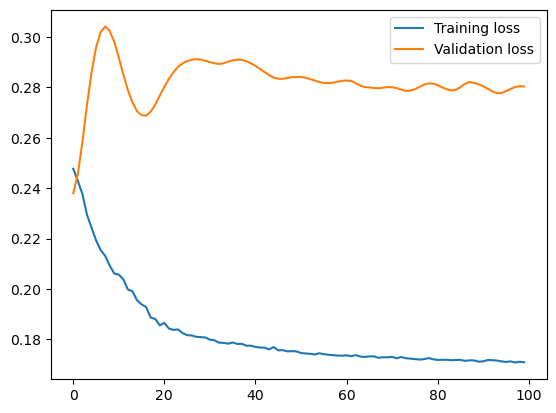

Results summary
Results in .\CPU-PV_W20_H20-gru-rs
Showing 1 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 22 summary
Hyperparameters:
units: 30
dropout: 0.1730761244103369
learning_rate: 0.01
Score: 0.24310948699712753
12/12 [==============================] - 0s 2ms/step - loss: 0.2144 - mean_absolute_error: 0.2128 - rmse: 0.2658
Score: [0.2143973559141159, 0.21283923089504242, 0.2657586634159088]


In [16]:
# Model evaluation:
print("------------------------------------------------------")
print("SUMMARY")
print("------------------------------------------------------")

print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))

# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Results summary
gruOptimizer.results_summary(num_trials = 1)

# Model evaluation with test data
score = model.evaluate(xtest, ytest)
print('Score:', score)

In [17]:
# Model training:
#with tf.device('/gpu:0'): 
    # Create optimizer
gruOptimizerBO = BayesianOptimization(build_model, 
                            objective = objective,
                            max_trials = trials, 
                            executions_per_trial = executions,
                            project_name = projectNameBO,
                            overwrite=True)

# gruOptimizerBO.search_space_summary()

# Search execution with epochs
initialTime = time.time()
gruOptimizerBO.search(x = xtrain,
                    y = ytrain, 
                    epochs = epchs,
                    batch_size = batch,
                    validation_data = (xval, yval),
                    verbose = 1)
finalTime = time.time()

# Get best model generated
model = gruOptimizerBO.get_best_models(num_models = numBestModels)[0]

# Model training with epochs 
history = model.fit(
            xtrain,
            ytrain,
            epochs = epchs,
            batch_size = batch,
            validation_data=(xval, yval))

# Show model info
print(history.history.keys())
print(model.history.history)
print(model.history.params)

Trial 40 Complete [00h 00m 16s]
val_mean_absolute_error: 0.2578539103269577

Best val_mean_absolute_error So Far: 0.24632395058870316
Total elapsed time: 00h 09m 56s
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2483 - mean_absolute_error: 0.2483 - rmse: 0.3123 - val_loss: 0.2578 - val_mean_absolute_error: 0.2578 - val_rmse: 0.3190
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2455 - mean_absolute_error: 0.2455 - rmse: 0.3111 - val_loss: 0.2785 - val_mean_absolute_error: 0.2785 - val_rmse: 0.3405
Epoch 3/100
1/1 [==============================] - 0s 32ms/step - loss: 0.2476 - mean_absolute_error: 0.2476 - rmse: 0.3154 - val_loss: 0.2940 - val_mean_absolute_error: 0.2940 - val_rmse: 0.3551
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2381 - mean_absolute_error: 0.2381 - rmse: 0.3017 - val_loss: 0.3031 - val_mean_absolute_error: 0.3031 - val_rmse: 0.3616
Epoch 5/100
1/1 [==============================] - 0

------------------------------------------------------
SUMMARY BO
------------------------------------------------------
Tiempo de entrenamiento (en segundos):	595.749470949173


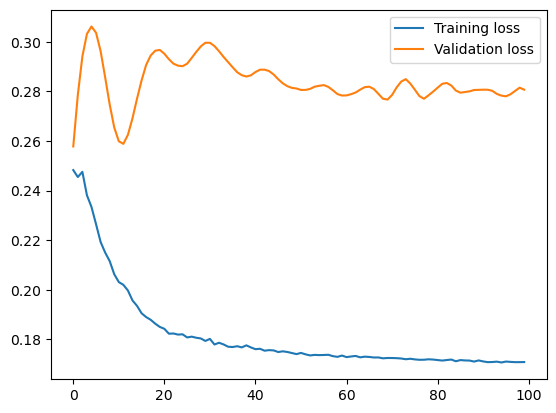

Results summary
Results in .\CPU-PV_W20_H20-gru-bo
Showing 1 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 29 summary
Hyperparameters:
units: 50
dropout: 0.33
learning_rate: 0.01
Score: 0.24632395058870316
12/12 [==============================] - 0s 2ms/step - loss: 0.2148 - mean_absolute_error: 0.2132 - rmse: 0.2662
Score: [0.21482647955417633, 0.21323111653327942, 0.26616987586021423]


In [18]:
# Model evaluation:
print("------------------------------------------------------")
print("SUMMARY BO")
print("------------------------------------------------------")

print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))

# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Results summary
gruOptimizerBO.results_summary(num_trials = 1)

# Model evaluation with validation data
score = model.evaluate(xtest, ytest)
print('Score:', score)